# This file converts the CT scans from DICOM format to numpy arrays

## This notebook is organised as follows:
## Set up 
 * make configuration file with conversion parameters and file location
 * calculate median score (1-5) from 4 radiologists 
 * save meta data
 
## Convert data and view
 * convert each DICOM file to numpy array
 * remove any image with mask containing less than 8 pixels
 * crop images to ROI of 64x64 based on centre of segmentation mask
 * view example images with segmentation masks

## Find and remove 64 images which have the centre of segmentation mask within 32 of its border 
 
## Bounding box working out/experimenting 

In [2]:
import argparse
import os
import numpy as np

from medpy.filter.smoothing import anisotropic_diffusion
from scipy.ndimage import median_filter
from skimage import measure, morphology
import scipy.ndimage as ndimage
from sklearn.cluster import KMeans

import sys
import os
from pathlib import Path
import glob
from configparser import ConfigParser
import pandas as pd
import warnings
import pylidc as pl
from tqdm import tqdm
from statistics import median_high

from pylidc.utils import consensus
from PIL import Image


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
import math

from scipy.ndimage import label, generate_binary_structure
from sklearn.metrics.pairwise import euclidean_distances


In [3]:
from configparser import ConfigParser

if __name__ == "__main__":
    # This python file creates a configuartion file. Change the below directories for your application

    config = ConfigParser()

    # prepare_dataset.py configuration
    config['dicom'] = {
         #path to DICOM data
        'Path': r"D:\aMaster\thesis_dataset\LUNG\LIDC-IDRI",
        'Warn': True
    }

    # Create the configuration file and put it in home drive
    with open(r"C:\Users\10735\pylidc.conf", 'w') as f:
          config.write(f)

In [4]:
if __name__ == "__main__":
    # This python file creates a configuartion file. Change the below directories for your application

    config = ConfigParser()

    # prepare_dataset.py configuration
    config['prepare_dataset'] = {
        #Path To LIDC Dataset
        'LIDC_DICOM_PATH': r"D:\aMaster\thesis_dataset\LUNG\LIDC-IDRI",
        # Directory to save the output files
        # Directory for masks
        'MASK_PATH': r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\Mask",
        # Directory for images
        'IMAGE_PATH': r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\Images",

        # CSV file containing nodule information, malignancy, train test split
        'META_PATH': r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\Meta",
        # Mask Threshold is the np.sum(MASK) threshold. Some Masks are too small. We remove these small images, 
        # masks as they might act as outliers
        # The threshold 8 was decided by empirical evaluation.
        'Mask_Threshold':8
    }


    # This is the configuration file for pylidc library
    config['pylidc'] = {
        # Confidence level determines the overlap between the 4 doctors who have made annotation
        'confidence_level': 0.5,
        # 512 determines the size of the image
        'padding_size': 512
    }

    # Create the configuration file in lung.conf
    with open('./lung.conf', 'w') as f:
          config.write(f)

In [5]:
IMAGE_DIR = r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\Images"
MASK_DIR =  r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\Mask"

In [11]:
warnings.filterwarnings(action='ignore')

# Read the configuration file generated from config_file_create.py
parser = ConfigParser()
parser.read('lung.conf')
#lung_config_path = r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\config\lung.conf"
#parser.read(lung_config_path)

# 修改 pylidc 库的一些 bug
#np.int = int
#configparser.SafeConfigParser = configparser.ConfigParser

def is_dir_path(path):
    abs_path = os.path.abspath(path)
    if not os.path.exists(abs_path):
        raise FileNotFoundError(f"路径不存在：{abs_path}")
    return abs_path

#Get Directory setting
DICOM_DIR = is_dir_path(parser.get('prepare_dataset','LIDC_DICOM_PATH'))
MASK_DIR = is_dir_path(parser.get('prepare_dataset','MASK_PATH'))
IMAGE_DIR = is_dir_path(parser.get('prepare_dataset','IMAGE_PATH'))
META_DIR = is_dir_path(parser.get('prepare_dataset','META_PATH'))

#Hyper Parameter setting for prepare dataset function
mask_threshold = parser.getint('prepare_dataset','Mask_Threshold')

#Hyper Parameter setting for pylidc
confidence_level = parser.getfloat('pylidc','confidence_level')
padding = parser.getint('pylidc','padding_size')

class MakeDataSet:
    def __init__(self, LIDC_Patients_list, IMAGE_DIR, MASK_DIR,META_DIR, mask_threshold, padding, confidence_level=0.5):
        self.IDRI_list = LIDC_Patients_list
        self.img_path = IMAGE_DIR
        self.mask_path = MASK_DIR
        self.meta_path = META_DIR
        self.mask_threshold = mask_threshold
        self.c_level = confidence_level
        self.padding = [(padding,padding),(padding,padding),(0,0)]
        self.meta = pd.DataFrame(index=[],columns=['patient_id','nodule_no','slice_no','original_image','mask_image',
                                                   'malignancy','is_cancer','is_clean'])


    def calculate_malignancy(self,nodule):
        ''' 
        Calculate the malignancy of a nodule with the annotations made by 4 doctors. 
        Return median high of the annotated cancer, True or False label for cancer,
        if median high is above 3, we return a label True for cancer,
        if it is below 3, we return a label False for non-cancer,
        if it is 3, we return ambiguous.
        '''
        list_of_malignancy =[]
        for annotation in nodule:
            list_of_malignancy.append(annotation.malignancy)

        malignancy = median_high(list_of_malignancy)
        if  malignancy > 3:
            return malignancy, True
        elif malignancy < 3:
            return malignancy, False
        else:
            return malignancy, 'Ambiguous'
        
    def save_meta(self,meta_list):
        """Saves the information of nodule to csv file"""
        tmp = pd.Series(meta_list,index=['patient_id','nodule_no','slice_no','original_image','mask_image','malignancy','is_cancer','is_clean'])
        #self.meta = self.meta.append(tmp,ignore_index=True)
        self.meta = pd.concat([self.meta, tmp.to_frame().T], ignore_index=True)

    def prepare_dataset(self):
        # This names each image and mask
        prefix = [str(x).zfill(3) for x in range(1000)]
    
        # Make directory
        if not os.path.exists(self.img_path):
            os.makedirs(self.img_path)
        if not os.path.exists(self.mask_path):
            os.makedirs(self.mask_path)
        if not os.path.exists(self.meta_path):
            os.makedirs(self.meta_path)
    
        IMAGE_DIR = Path(self.img_path)
        MASK_DIR = Path(self.mask_path)
    
        x = 62
        y = 62
        bbox_list = []
        image_size_list = []
        min_max_x = []
        min_max_y = []
        
        for patient in tqdm(self.IDRI_list):
            pid = patient  # e.g. LIDC-IDRI-0001
            
            try:
                scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
                nodules_annotation = scan.cluster_annotations()
                vol = scan.to_volume()
    
                print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(pid, vol.shape, len(nodules_annotation)))
    
                patient_image_dir = IMAGE_DIR
                patient_mask_dir = MASK_DIR
    
                if len(nodules_annotation) > 0:
                    # Patients with nodules
                    for nodule_idx, nodule in enumerate(nodules_annotation):
                        # Call nodule images. Each Patient will have at maximum 4 annotations as there are only 4 doctors
                        # This current for loop iterates over total number of nodules in a single patient
                        mask, cbbox, masks = consensus(nodule, self.c_level, self.padding)
                        lung_np_array_start = vol[cbbox]
    
                        # We calculate the malignancy information
                        malignancy, cancer_label = self.calculate_malignancy(nodule)
    
                        for nodule_slice in range(mask.shape[2]):
                            # This second for loop iterates over each single nodule.
                            # There are some mask sizes that are too small. These may hinder training.
                            if np.sum(mask[:, :, nodule_slice]) <= self.mask_threshold:
                                continue
                                
                            lung_np_array = lung_np_array_start[:, :, nodule_slice]
                            lung_np_array[lung_np_array == -0] = 0
                            
                            # This iterates through the slices of a single nodule
                            y_idx, x_idx = np.where(mask[:, :, nodule_slice] == True)
                            
                            # Find the index locations of 'True' in the mask i.e. where lesion located 
                            min_max_x.append([min(x_idx), max(x_idx)])
                            min_max_y.append([min(y_idx), max(y_idx)])
                            
                            # Find exact middle of lesion using (min+max)/2 
                            center = [(max(y_idx) + min(y_idx)) / 2, (max(x_idx) + min(x_idx)) / 2]
                            
                            # Bounding box calculation to ensure it is 64x64
                            bbox = [int(np.floor(center[0] - (y / 2))), int(np.ceil(center[0] + (y / 2)) + 1),
                                    int(np.floor(center[1] - (x / 2))), int(np.ceil(center[1] + (x / 2)) + 1)]
                            
                            if center[0]%1 == 0:
                                bbox = [int(np.floor(center[0]-(y/2)))-1,int(np.ceil(center[0]+(y/2))+1), 
                                        int(np.floor(center[1]-(x/2))), int(np.ceil(center[1]+(x/2))+1)]
                        
                            if center[1]%1 == 0:
                                bbox = [int(np.floor(center[0]-(y/2))),int(np.ceil(center[0]+(y/2))+1), 
                                        int(np.floor(center[1]-(x/2)))-1, int(np.ceil(center[1]+(x/2))+1)]
                        
                            if center[0]%1 == 0 and center[1]%1 == 0:
                                bbox = [int(np.floor(center[0]-(y/2)))-1,int(np.ceil(center[0]+(y/2))+1), 
                                        int(np.floor(center[1]-(x/2)))-1, int(np.ceil(center[1]+(x/2))+1)]
                                
                            bbox_list.append(bbox)
                            image_size_list.append([bbox[1] - bbox[0], bbox[3] - bbox[2]])
                            lung_np_array = lung_np_array[bbox[0]:bbox[1], bbox[2]:bbox[3]]
                            
                            # Naming of each file: NI= Nodule Image, MA= Mask Original 
                            nodule_name = "{}_NI{}_slice{}".format(pid[-4:], prefix[nodule_idx], prefix[nodule_slice])
                            mask_name = "{}_MA{}_slice{}".format(pid[-4:], prefix[nodule_idx], prefix[nodule_slice])
                            meta_list = [pid[-4:], nodule_idx, prefix[nodule_slice], nodule_name, mask_name, malignancy, cancer_label, False]
                            
                            mask2 = mask[:, :, nodule_slice]
                            mask2 = mask2[bbox[0]:bbox[1], bbox[2]:bbox[3]]
                            
                            # Save meta data, images and masks as numpy arrays
                            self.save_meta(meta_list)
                            np.save(patient_image_dir / nodule_name, lung_np_array)
                            np.save(patient_mask_dir / mask_name, mask2)
            
            except Exception as e:
                # 检查异常是否为 ClusterError
                if "ClusterError" in str(e):
                    print(f"ClusterError encountered for Patient ID: {pid}. Skipping...")
                    with open('skipped_patients.txt', 'a') as log_file:
                        log_file.write(f"{pid}\n")
                else:
                    print(f"Unexpected error for Patient ID: {pid}: {str(e)}")

    
        print("Saved Meta data")
        # Save meta_info.csv
        self.meta.to_csv(os.path.join(self.meta_path, 'meta_info.csv'), index=False)
    
        # Save bounding box data
        np.save(r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\bbox", bbox_list)
        np.save(r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\image-size", image_size_list)
        np.save(r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\minmaxX", min_max_x)
        np.save(r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\minmaxY", min_max_y)


if __name__ == '__main__':
    # I found out that simply using os.listdir() includes the gitignore file 
    LIDC_IDRI_list= [f for f in os.listdir(DICOM_DIR) if not f.startswith('.')]
    LIDC_IDRI_list.sort()
    if 'LICENSE' in LIDC_IDRI_list:
        LIDC_IDRI_list.remove('LICENSE')


    test= MakeDataSet(LIDC_IDRI_list,IMAGE_DIR,MASK_DIR,META_DIR,mask_threshold,padding,confidence_level)
    test.prepare_dataset()

  0%|                                                                                         | 0/1010 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0001 Dicom Shape: (512, 512, 133) Number of Annotated Nodules: 1


  0%|                                                                               | 1/1010 [00:06<1:46:23,  6.33s/it]

Loading dicom files ... This may take a moment.


  0%|                                                                               | 1/1010 [00:11<3:07:35, 11.15s/it]


KeyboardInterrupt: 

In [19]:
def view_img(MASK_DIR,IMAGE_DIR,im_range):
    '''
    function to print images within a range alongside the corresponding segmentation mask
    '''
    
    for image in sorted(os.listdir(IMAGE_DIR))[im_range[0]:im_range[1]]:
        pid = image[:4]
        image_id = image
        mask_id = image.replace('NI','MA')
        print(image)
        print(mask_id)
        print(pid)
        
        original_img = np.load(IMAGE_DIR+'/'+image_id)
        mask_img= np.load(MASK_DIR+'/'+mask_id)
        print(np.shape(original_img))

        fig,ax = plt.subplots(1,2, figsize=(15,15))
        ax[0].title.set_text('Original image')
        ax[0].imshow(original_img)
        ax[0].grid()
        ax[1].title.set_text('Mask image')
        ax[1].imshow(mask_img)
        ax[1].grid()
        plt.show()
        
        
def is_dir_path(string):
    if os.path.isdir(string):
        return string
    else:
        raise NotADirectoryError(string)

0007_NI001_slice008.npy
0007_MA001_slice008.npy
0007
(64, 64)


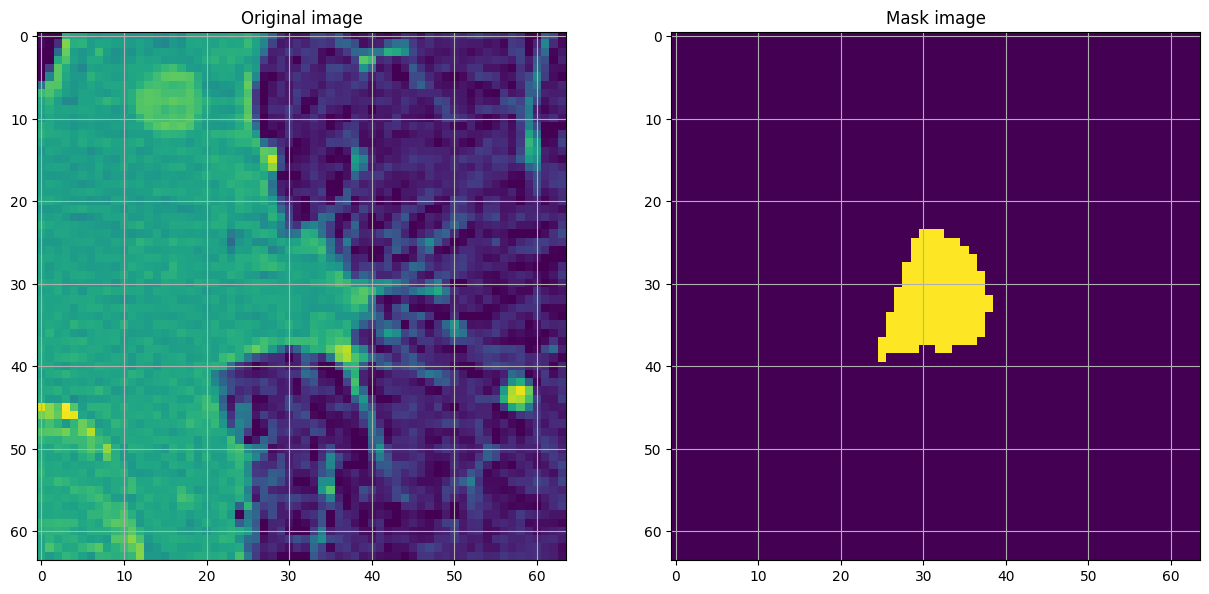

0007_NI001_slice009.npy
0007_MA001_slice009.npy
0007
(64, 64)


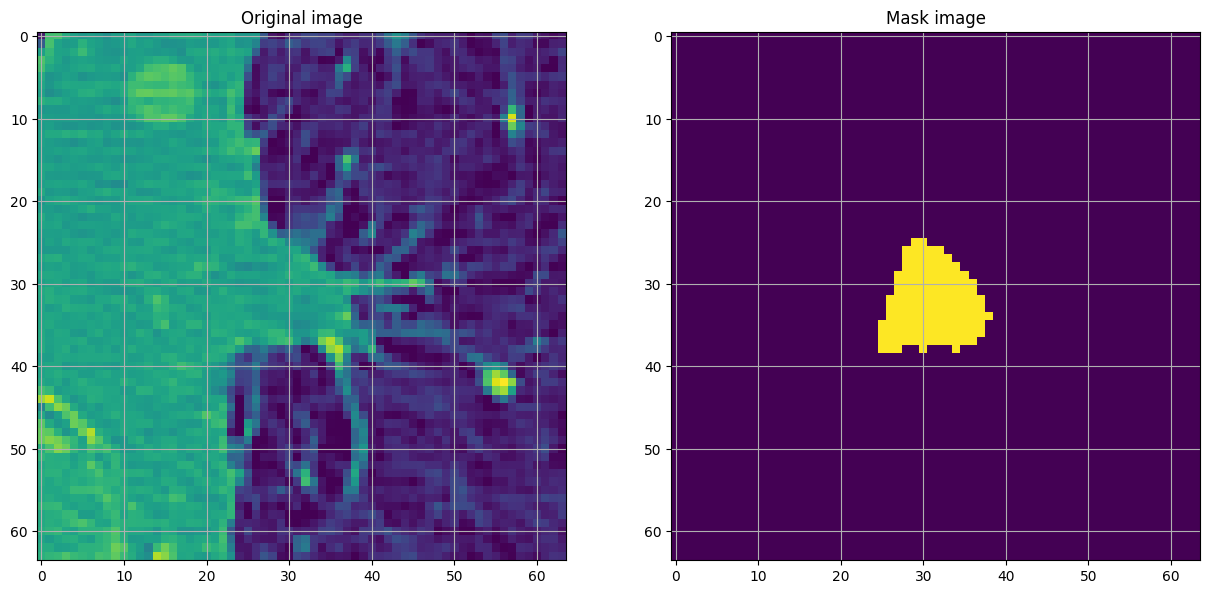

0007_NI001_slice010.npy
0007_MA001_slice010.npy
0007
(64, 64)


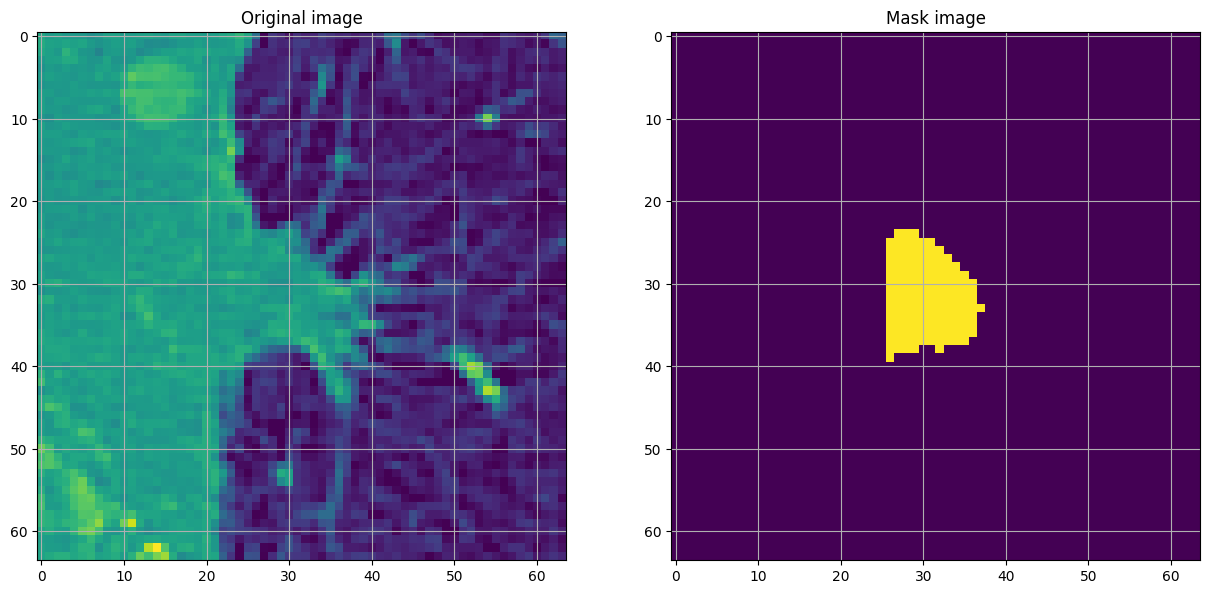

0007_NI001_slice011.npy
0007_MA001_slice011.npy
0007
(64, 64)


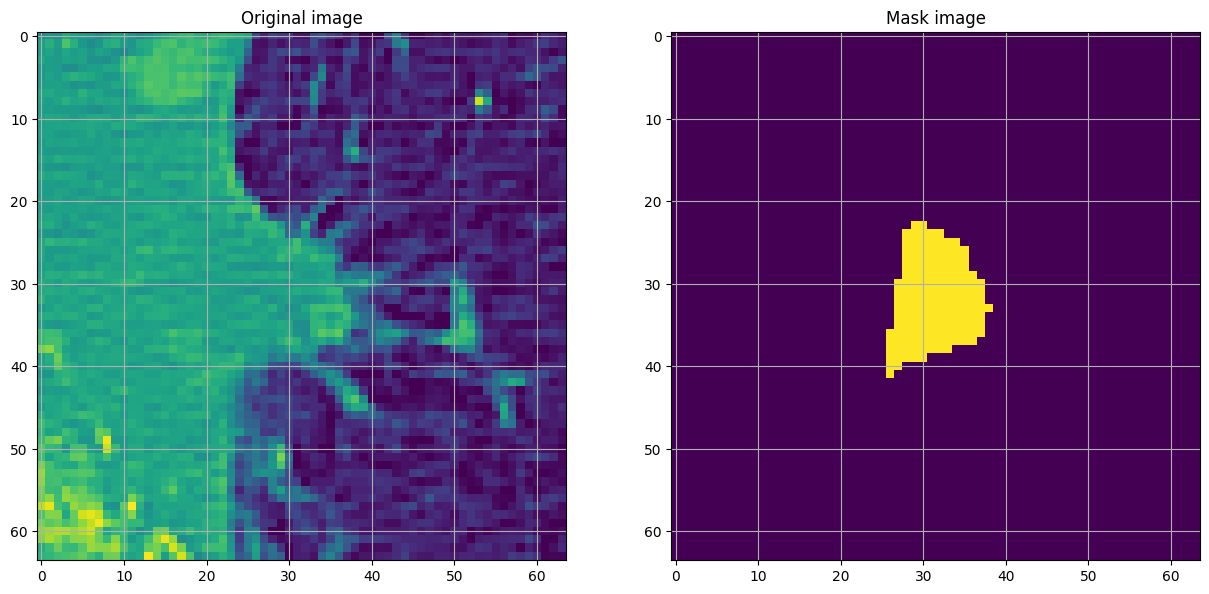

0008_NI000_slice000.npy
0008_MA000_slice000.npy
0008
(64, 64)


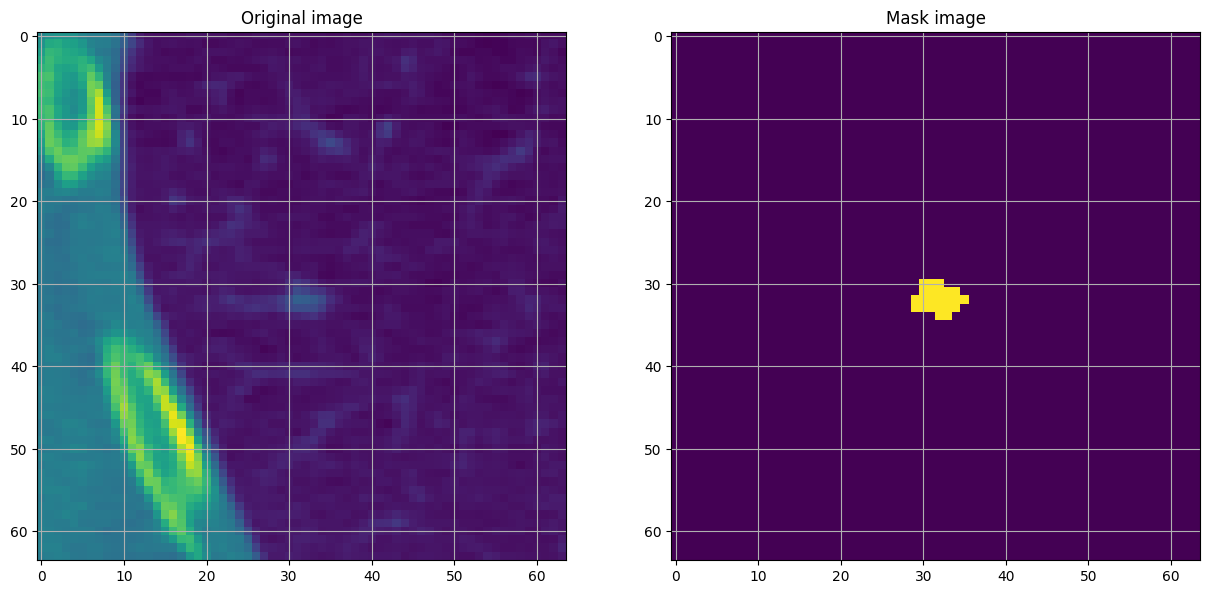

0008_NI000_slice001.npy
0008_MA000_slice001.npy
0008
(64, 64)


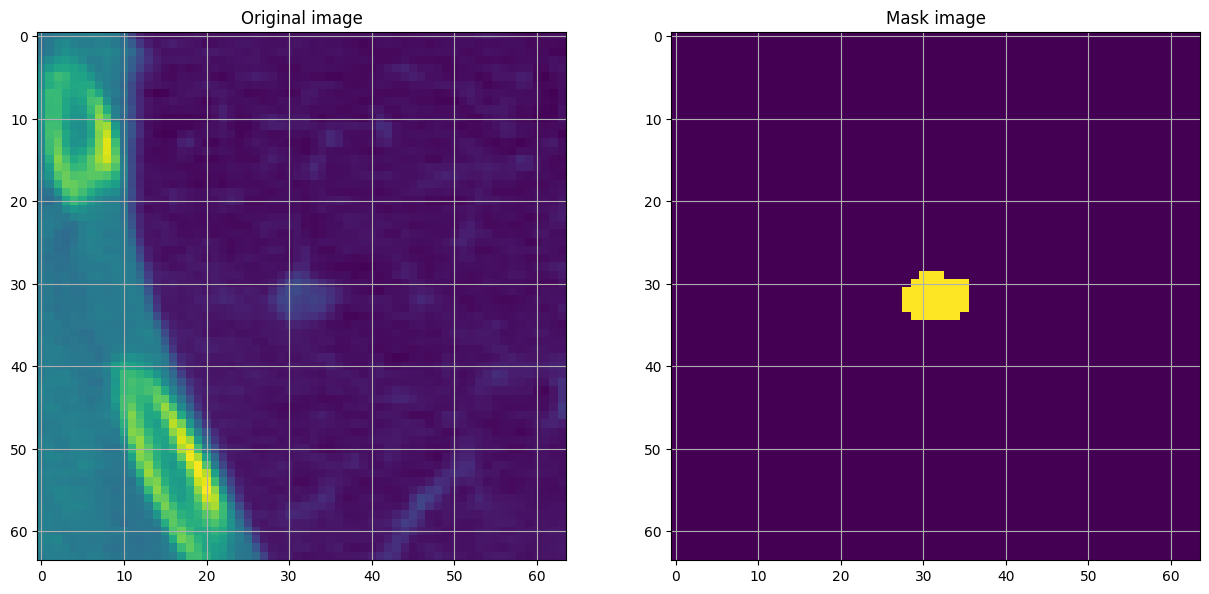

0008_NI001_slice001.npy
0008_MA001_slice001.npy
0008
(64, 64)


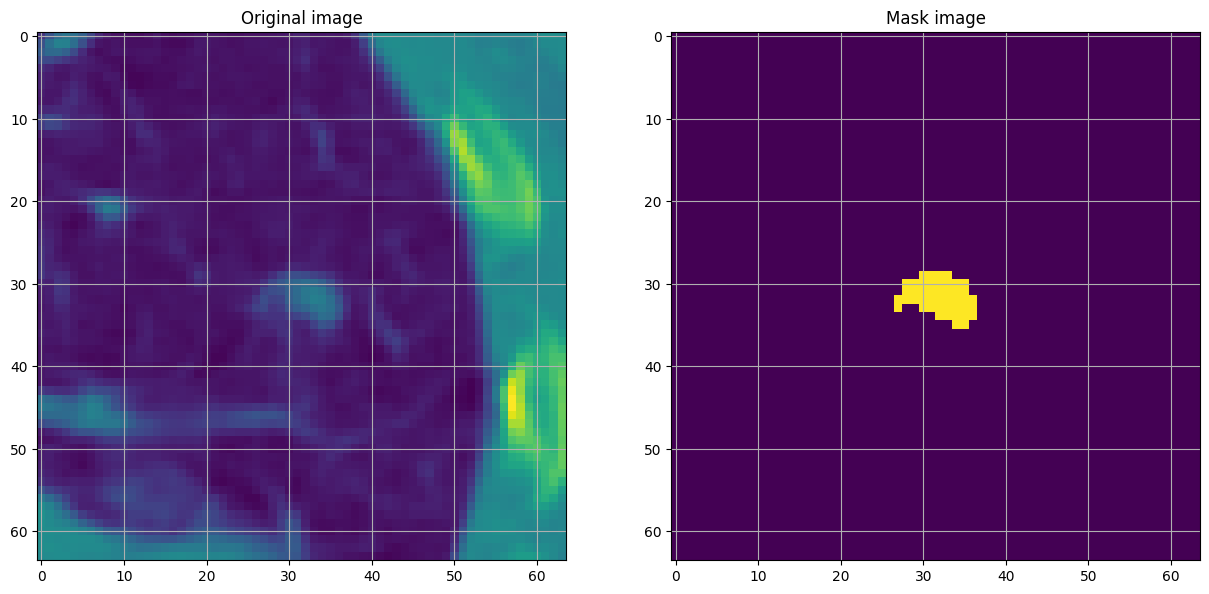

0008_NI001_slice002.npy
0008_MA001_slice002.npy
0008
(64, 64)


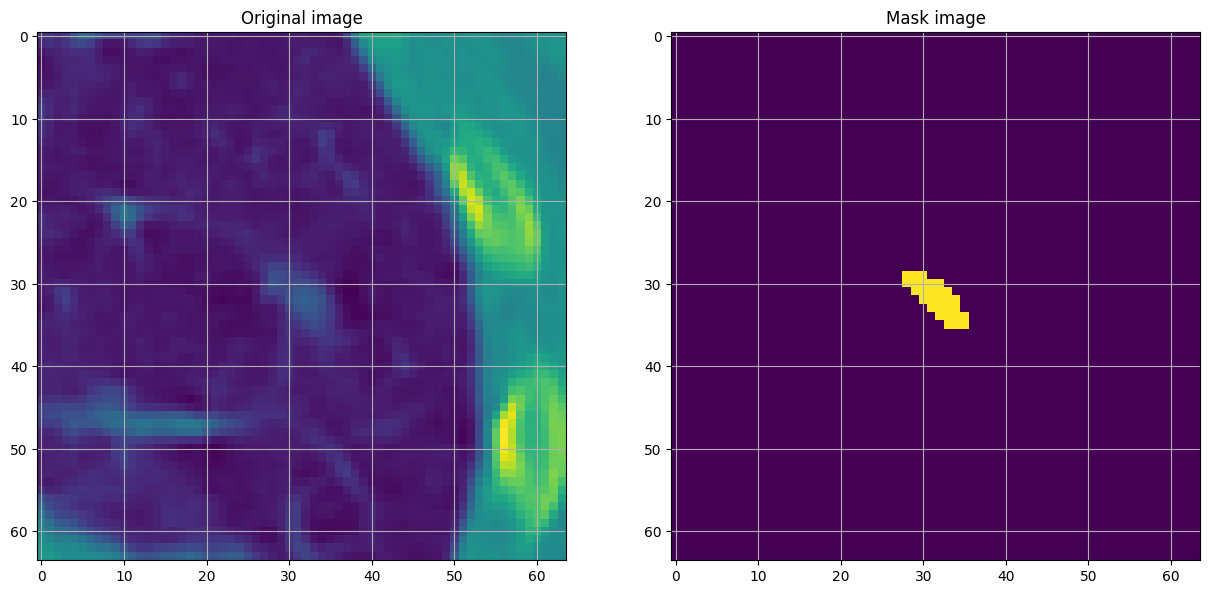

0009_NI000_slice000.npy
0009_MA000_slice000.npy
0009
(64, 64)


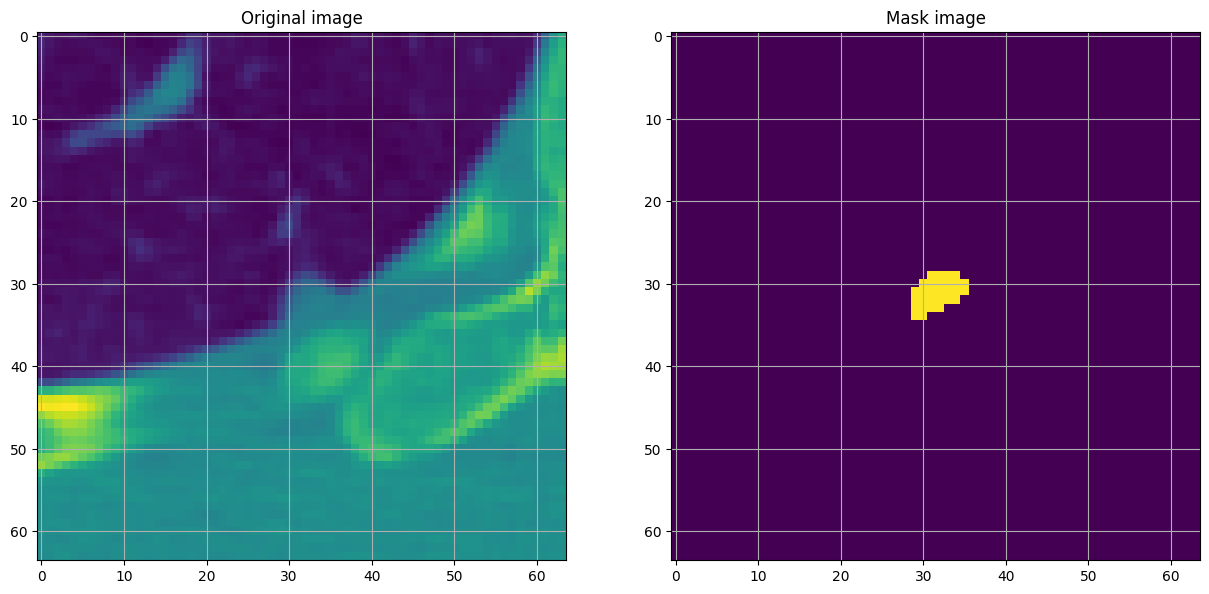

0009_NI000_slice001.npy
0009_MA000_slice001.npy
0009
(64, 64)


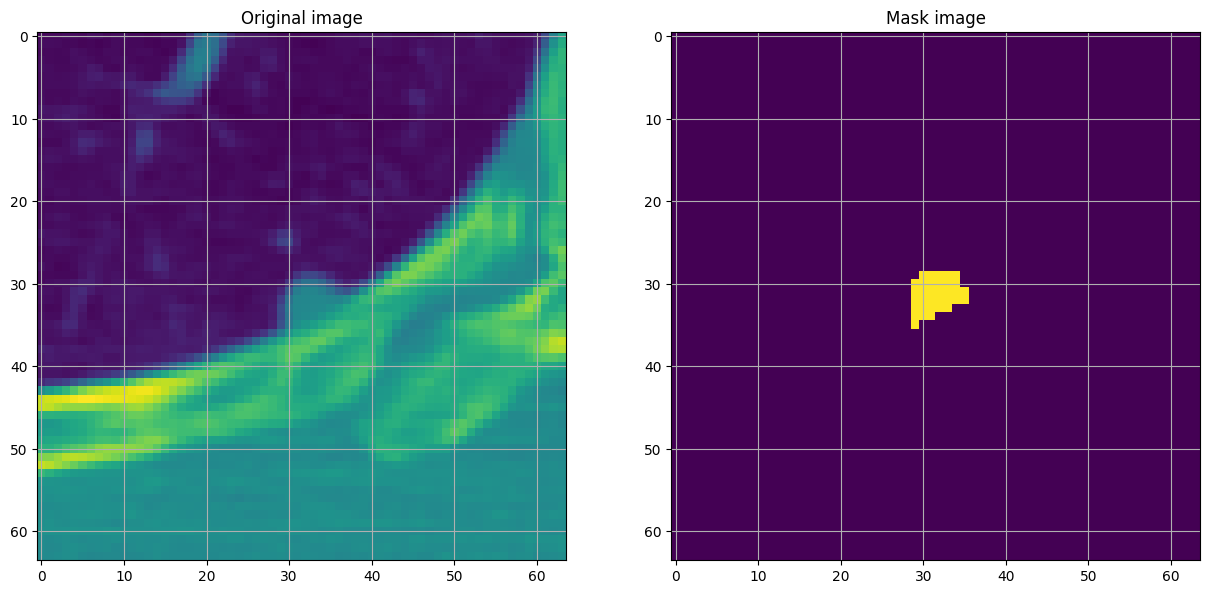

0009_NI000_slice002.npy
0009_MA000_slice002.npy
0009
(64, 64)


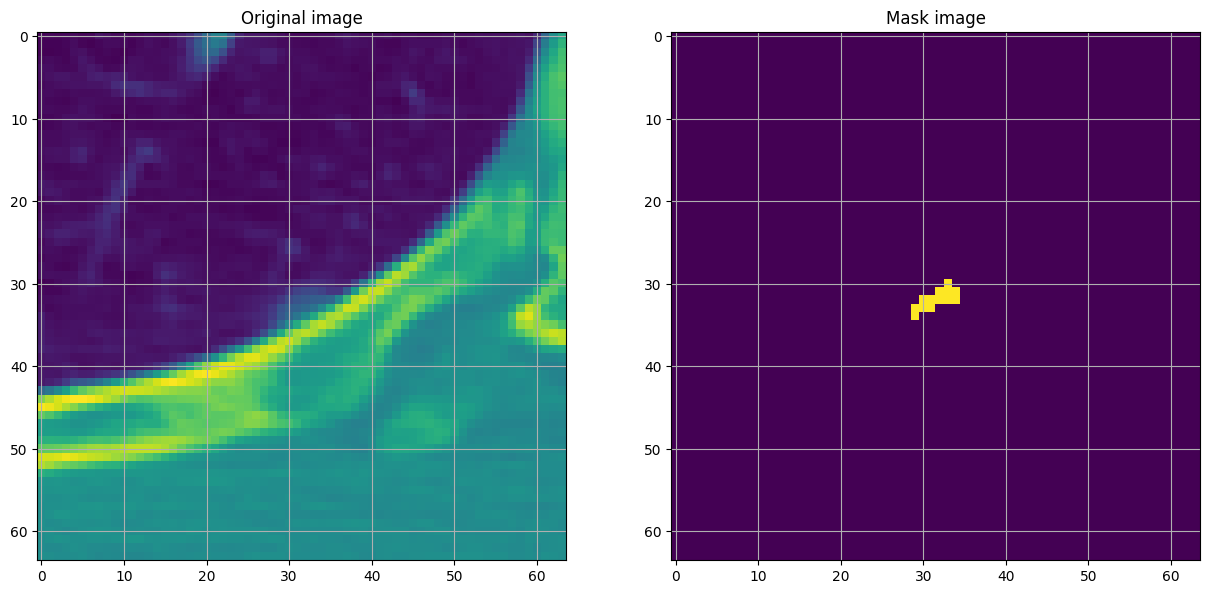

0009_NI001_slice001.npy
0009_MA001_slice001.npy
0009
(64, 64)


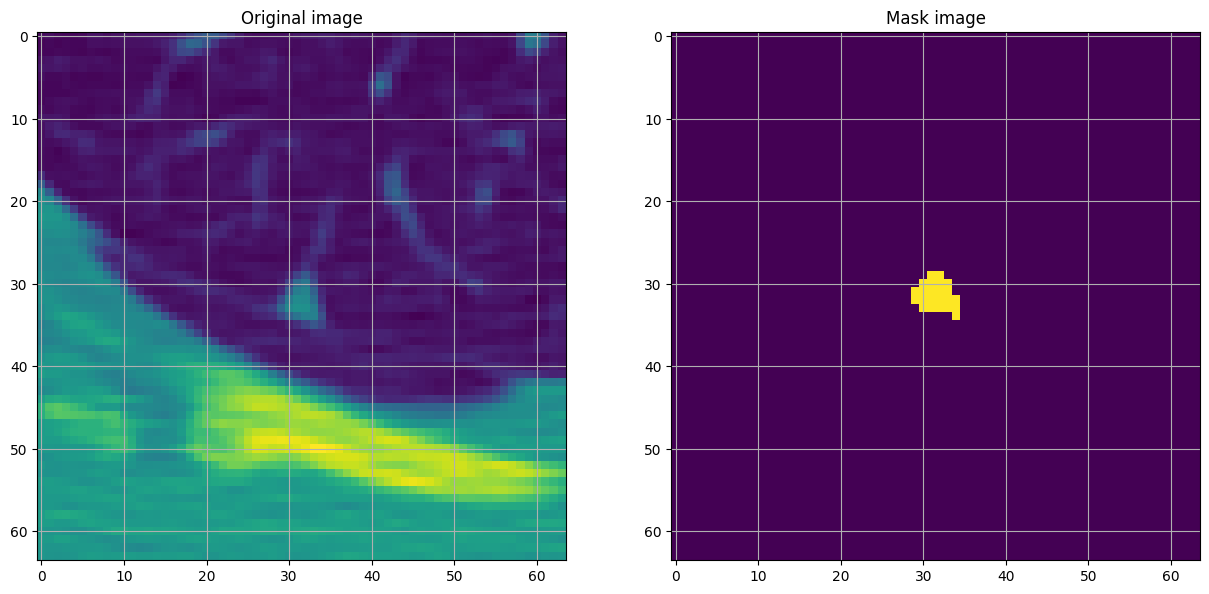

0009_NI001_slice002.npy
0009_MA001_slice002.npy
0009
(64, 64)


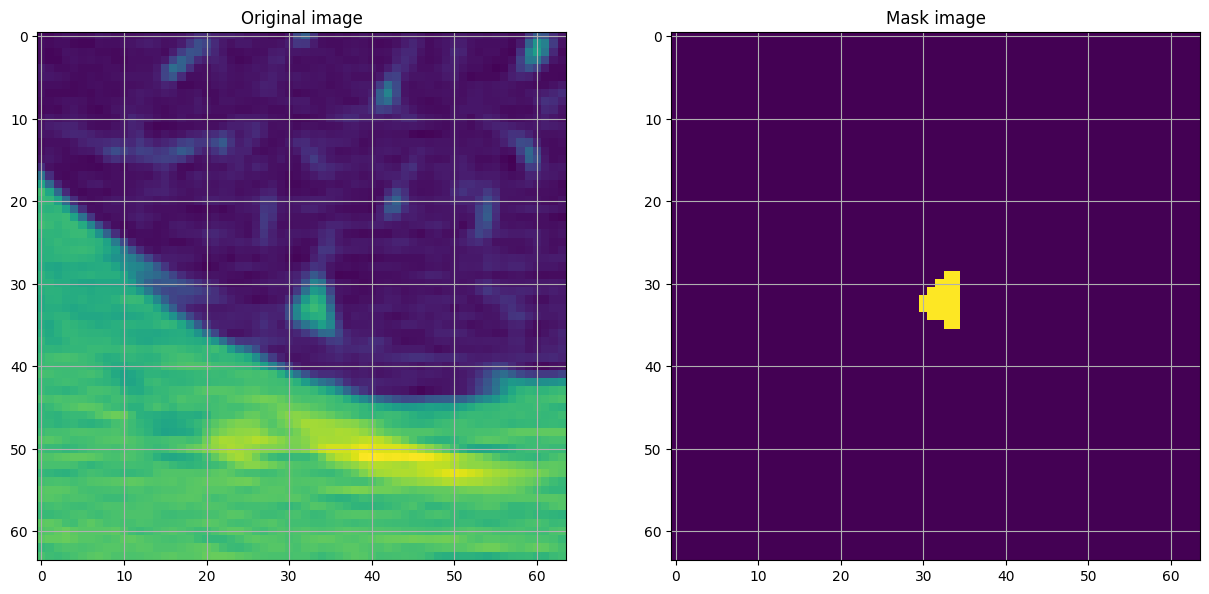

0009_NI001_slice003.npy
0009_MA001_slice003.npy
0009
(64, 64)


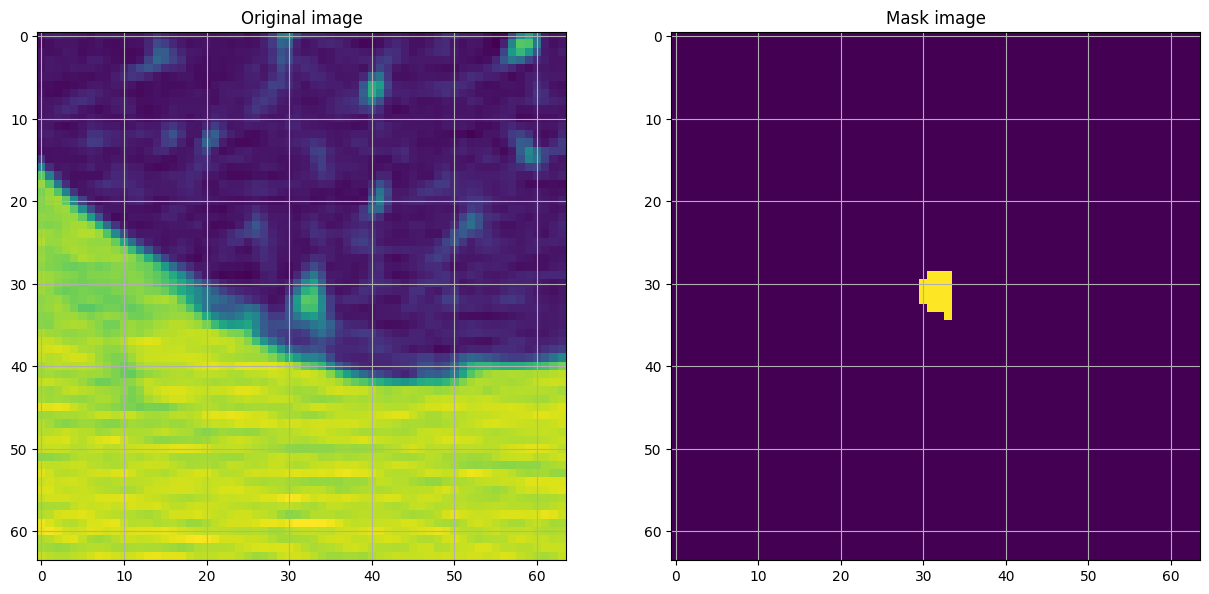

0010_NI000_slice001.npy
0010_MA000_slice001.npy
0010
(64, 64)


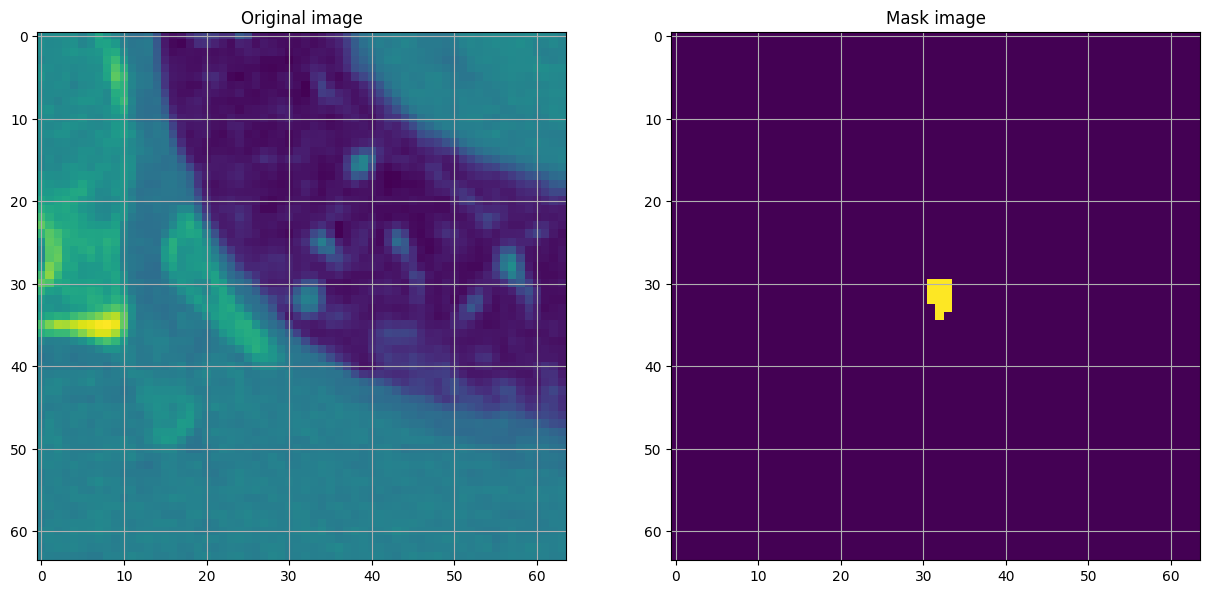

In [20]:
view_img(MASK_DIR,IMAGE_DIR,[100,115])

In [20]:
# find images which need to be removed becuase centre is too close to edge of image 
# meaning bounding box crosses image border

image_size_list = np.load(r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\image-size.npy")
for size in image_size_list:
    if size[0] != 64 or size[1] != 64:
        print(size)

bbox_list = np.load(r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\bbox.npy")
i = -1
index_list = []
for bbox in bbox_list:
    i+=1
    for j in range(-100,1):
        if j in bbox:
            print(bbox,i)
            index_list.append(i)
    for k in range(512,600):
        if k in bbox:
            print(bbox,i)
            index_list.append(i)
    

print(len(index_list))
print(index_list)

[250 314 457 521] 5634
[250 314 458 522] 5635
[250 314 457 521] 5636
[249 313 457 521] 5637
[249 313 457 521] 5638
[248 312 458 522] 5639
[249 313 457 521] 5640
[249 313 457 521] 5641
[248 312 457 521] 5642
[248 312 457 521] 5643
[248 312 458 522] 5644
[248 312 457 521] 5645
[196 260 -15  49] 6015
[196 260 -15  49] 6016
[196 260 -14  50] 6017
[197 261 -14  50] 6018
[197 261 -14  50] 6019
[197 261 -13  51] 6020
[197 261 -12  52] 6021
[197 261 -13  51] 6022
[197 261 -12  52] 6023
[198 262 -12  52] 6024
[197 261 -13  51] 6025
[198 262 -14  50] 6026
[198 262 -15  49] 6027
[196 260 453 517] 8329
[196 260 453 517] 8330
[196 260 453 517] 8331
[195 259 453 517] 8332
[195 259 452 516] 8333
[195 259 452 516] 8334
[195 259 452 516] 8335
[195 259 453 517] 8336
[233 297  -1  63] 12731
[234 298  -1  63] 12732
[234 298  -1  63] 12733
[235 299   0  64] 12734
[235 299   0  64] 12746
[236 300  -1  63] 12747
[213 277 455 519] 13261
[213 277 455 519] 13262
[212 276 454 518] 13263
[212 276 454 518] 13264
4

In [22]:
DICOM_DIR = r"D:\aMaster\github_code\VAE_lung_lesion_BMVC\Data\Mask"

# 获取 Mask 目录中的所有 .npy 文件
all_files_list = [f for f in os.listdir(DICOM_DIR) if f.endswith('.npy')]

# 排序
all_files_list.sort()

print(len(all_files_list))
print(all_files_list[0:5])

13607
['0001_MA000_slice000.npy', '0001_MA000_slice001.npy', '0001_MA000_slice002.npy', '0001_MA000_slice003.npy', '0001_MA000_slice004.npy']


In [23]:
print(len(index_list))
index_list = sorted(index_list)
files = []
for a in index_list:
    b = all_files_list[a]
    b = b.replace('MA', 'NI')
    files.append(b)
print(sorted(files))

43
['0463_NI000_slice001.npy', '0463_NI000_slice002.npy', '0463_NI000_slice003.npy', '0463_NI000_slice004.npy', '0463_NI000_slice005.npy', '0463_NI000_slice006.npy', '0463_NI000_slice007.npy', '0463_NI000_slice008.npy', '0463_NI000_slice009.npy', '0463_NI000_slice010.npy', '0463_NI000_slice011.npy', '0463_NI000_slice012.npy', '0487_NI000_slice002.npy', '0487_NI000_slice003.npy', '0487_NI000_slice004.npy', '0487_NI000_slice005.npy', '0487_NI000_slice006.npy', '0487_NI000_slice007.npy', '0487_NI000_slice008.npy', '0487_NI000_slice009.npy', '0487_NI000_slice010.npy', '0487_NI000_slice011.npy', '0487_NI000_slice012.npy', '0487_NI000_slice013.npy', '0487_NI000_slice014.npy', '0655_NI002_slice000.npy', '0655_NI002_slice001.npy', '0655_NI002_slice002.npy', '0655_NI002_slice003.npy', '0655_NI002_slice004.npy', '0655_NI002_slice005.npy', '0655_NI002_slice006.npy', '0655_NI002_slice007.npy', '0951_NI000_slice000.npy', '0951_NI000_slice001.npy', '0951_NI000_slice002.npy', '0951_NI000_slice003.npy

In [24]:
# remove 64 images 
path = r"D:\\aMaster\\github_code\\VAE_lung_lesion_BMVC\\Data\\Images" + "\\"
for file in files:
    if file in os.listdir(IMAGE_DIR):
        os.remove(path + file)

In [25]:
len(sorted(os.listdir(IMAGE_DIR)))

13564

# Note:
### some patients have slices removed but others remaining: if considering multiple slices simultaneously remember to remove whole patient 

In [3]:
IMAGE_DIR = r"C:/Users/mm17b2k/Documents/ARCANE/Python/MSc/Data/Images"
a = sorted(os.listdir(IMAGE_DIR))
j=0
b_list = []
i_list=[]
for i in a:
    j+=1
    img = np.load(IMAGE_DIR+'/'+i)
    if np.shape(img) != (64,64):
        print(i, j, np.shape(img))
        i_list.append(i)
        b_list.append(j)

In [154]:
files_list = []
for file in all_files_list:
    files_list.append(file.replace('NI','MA'))
files_list[:10]

image_list = []
for file in files_list:
    file = file.replace('MA', 'NI')
    if file[16:] in i_list:
        image_list.append(file.replace('NI','MA'))
x, y = 62, 62
for a in image_list:
    mask = np.load(MASK_DIR + a)
    y_idx, x_idx = np.where(mask[:,:] == True)
    print([min(x_idx),max(x_idx)])
    print([min(y_idx),max(y_idx)])
    center = [(max(y_idx)+min(y_idx))/2, (max(x_idx)+min(x_idx))/2]
    print(center)
    bbox = [int(np.floor(center[0]-(y/2))),int(np.ceil(center[0]+(y/2))+1), 
            int(np.floor(center[1]-(x/2))), int(np.ceil(center[1]+(x/2))+1)]
    print(bbox)

[487, 490]
[280, 283]
[281.5, 488.5]
[250, 314, 457, 521]
[488, 491]
[279, 284]
[281.5, 489.5]
[250, 314, 458, 522]
[486, 491]
[278, 285]
[281.5, 488.5]
[250, 314, 457, 521]
[486, 492]
[277, 285]
[281.0, 489.0]
[250, 313, 458, 521]
[486, 492]
[277, 285]
[281.0, 489.0]
[250, 313, 458, 521]
[486, 493]
[275, 285]
[280.0, 489.5]
[249, 312, 458, 522]
[485, 493]
[276, 285]
[280.5, 489.0]
[249, 313, 458, 521]
[485, 492]
[276, 285]
[280.5, 488.5]
[249, 313, 457, 521]
[485, 492]
[275, 285]
[280.0, 488.5]
[249, 312, 457, 521]
[485, 493]
[276, 284]
[280.0, 489.0]
[249, 312, 458, 521]
[486, 493]
[276, 284]
[280.0, 489.5]
[249, 312, 458, 522]
[487, 491]
[276, 284]
[280.0, 489.0]
[249, 312, 458, 521]
[483, 487]
[227, 229]
[228.0, 485.0]
[197, 260, 454, 517]
[483, 487]
[226, 229]
[227.5, 485.0]
[196, 260, 454, 517]
[482, 488]
[225, 230]
[227.5, 485.0]
[196, 260, 454, 517]
[481, 488]
[224, 230]
[227.0, 484.5]
[196, 259, 453, 517]
[480, 487]
[224, 230]
[227.0, 483.5]
[196, 259, 452, 516]
[480, 488]
[22

In [6]:
IMAGE_DIR = r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\Data\Images\0001_NI000_slice000.npy"
MASK_DIR =  r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\Data\Mask\0001_MA000_slice000.npy"

original_img = np.load(IMAGE_DIR)
mask = np.load(MASK_DIR)

x = 62
y = 62
center = ndi.center_of_mass(mask)
center

(31.96564885496183, 32.19847328244275)

In [175]:
a = np.array([[0,0,1],
              [0,0,1],
              [0,0,1]])  

a = np.array([[0,0,0,0],
              [0,1,1,0],
              [0,0,1,0],
              [0,0,1,1],
              [0,1,0,0]])
a = np.array([[0,0,0,0,0,0],
              [1,0,1,0,1,0],
              [0,0,0,1,0,1],
              [0,1,1,1,1,1]])


print(ndi.center_of_mass(a))
y,x = np.where(a == 1)
centre = [(max(x)+min(x))/2, (max(y)+min(y))/2]
centre

(2.2, 2.9)


[2.5, 2.0]

In [220]:
a = 365.5
b = 316.1

bbox = [int(np.floor(a - 31)), int(np.ceil(a + 31))+1]
if a%1 == 0:
    bbox = [int(np.floor(a - 31))-1, int(np.ceil(a + 31))+1]

bbox[1] - bbox[0]

64